<a href="https://colab.research.google.com/github/ribesstefano/chalmers_dat340_applied_machine_learning/blob/main/assignment_2/DAT340_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group PA 47 - Author: Stefano Ribes, ribes@chalmers.se

This Notebook can be viewed online at this link: https://colab.research.google.com/drive/1sMNNrs7crcaSTpWAKSQG6BNoK8-KPbMg?usp=sharing

# Programming Assignment 2: Random Forests

## Task 0: Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

ASSIGNMENT_ID = 'assignment_2'

data_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
data_dir = os.path.join(data_dir, 'Colab Notebooks', 'dat340', ASSIGNMENT_ID)
data_dir = os.path.join(data_dir, 'data')
data_dir

'/content/drive/MyDrive/Colab Notebooks/dat340/assignment_2/data'

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

## Task 1: Working with a dataset with categorical features

### Step 1. Reading the data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

def get_dataset(filename):
    # Read the CSV file of data.
    data = pd.read_csv(filename).dropna()
    # Shuffle the dataset.
    data_shuffled = data.sample(frac=1.0, random_state=0)
    # Split into input part X and output part Y.
    X = data_shuffled.drop('target', axis=1)
    Y = data_shuffled['target'].to_frame()
    return X, Y

filename = os.path.join(data_dir, 'adult_train.csv')
Xtrain, Ytrain = get_dataset(filename)

filename = os.path.join(data_dir, 'adult_test.csv')
Xtest, Ytest = get_dataset(filename)

Xtest.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
15729,44,Private,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,48,United-States
7077,37,Private,HS-grad,9,Divorced,Exec-managerial,Unmarried,White,Female,0,0,50,United-States
14946,35,Private,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States
9416,38,State-gov,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States
5739,41,Private,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,5013,0,30,United-States


In [5]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(32561, 13)
(32561, 1)
(16281, 13)
(16281, 1)


### Step 2. Encoding the features as numbers.

In [6]:
from sklearn.feature_extraction import DictVectorizer

Xtrain.to_dict('records')[:2]

[{'age': 49,
  'capital-gain': 0,
  'capital-loss': 0,
  'education': 'HS-grad',
  'education-num': 9,
  'hours-per-week': 40,
  'marital-status': 'Married-civ-spouse',
  'native-country': 'United-States',
  'occupation': 'Transport-moving',
  'race': 'White',
  'relationship': 'Husband',
  'sex': 'Male',
  'workclass': 'Local-gov'},
 {'age': 49,
  'capital-gain': 0,
  'capital-loss': 0,
  'education': 'HS-grad',
  'education-num': 9,
  'hours-per-week': 40,
  'marital-status': 'Divorced',
  'native-country': 'United-States',
  'occupation': 'Other-service',
  'race': 'Black',
  'relationship': 'Not-in-family',
  'sex': 'Female',
  'workclass': 'Private'}]

In [7]:
dv = DictVectorizer(sparse=False)
# Input training data
Xtrain_encoded = dv.fit_transform(Xtrain.to_dict('records'))
# Input test data
Xtest_encoded = dv.transform(Xtest.to_dict('records'))
Xtrain_encoded.shape

(32561, 107)

Note that before the vetorization the dataset had 13 columns. After fitting the dataset instead, the resulting vectorized dataset now has 107 "columns" (i.e. features).

In [8]:
dv = DictVectorizer(sparse=False, separator='')
# Output training data
Ytrain_encoded = dv.fit_transform(Ytrain.to_dict('records'))
# Output testing data
Ytest_encoded = dv.transform(Ytest.to_dict('records'))
print(dv.get_feature_names_out(['target']))
print(type(Ytrain_encoded))
print(Ytrain_encoded.shape)
print(Ytrain_encoded)

['target<=50K' 'target>50K']
<class 'numpy.ndarray'>
(32561, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [11]:
# Baseline: Dummy Classifier
from sklearn.dummy import DummyClassifier
# Tree-based classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Linear classifiers
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
# Neural network classifier (will take longer time to train)
from sklearn.neural_network import MLPClassifier

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def aggregate_scores(scores):
    return scores.mean()

models = {
    'Baseline' : DummyClassifier(strategy='most_frequent'),
    'DecisionTreeClassifier' : DecisionTreeClassifier(max_depth=None), # None: till necessary
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=80), # 100
    # 'GradientBoostingClassifier' : GradientBoostingClassifier(n_estimators=100),
    # 'LogisticRegression' : LogisticRegression(solver='saga', max_iter=2000, tol=0.1, C=5.5),
    # 'Perceptron' : Perceptron(early_stopping=True, tol=0.01),
    # 'LinearSVC' : LinearSVC(dual=False, max_iter=2000, tol=0.0001, C=2.),
    'MLPClassifier' : MLPClassifier(hidden_layer_sizes=(32, 32, 32,), learning_rate_init=0.01, batch_size=128, max_iter=100),
}

scores = {}

for model_type in models.keys():
    model = models[model_type]
    score = aggregate_scores(cross_val_score(model, Xtrain_encoded, Ytrain_encoded))
    scores[model_type] = score
    print(f'INFO. Model {model_type} aggregated score: {score:.4f}')

best_model_type = max(scores, key=scores.get)
print('=' * 80)
print(f'INFO. Best Model is {best_model_type} with score: {scores[best_model_type]:.4f}')

INFO. Model Baseline aggregated score: 0.7592
INFO. Model DecisionTreeClassifier aggregated score: 0.8071
INFO. Model RandomForestClassifier aggregated score: 0.8443


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


INFO. Model MLPClassifier aggregated score: 0.8276
INFO. Best Model is RandomForestClassifier with score: 0.8443


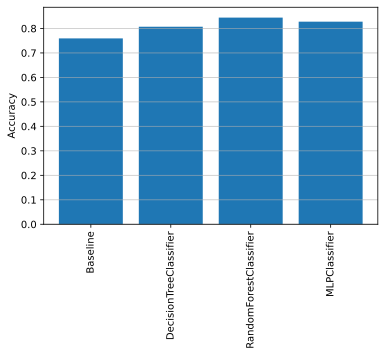

In [14]:
import matplotlib.pyplot as plt

linspace = [x for x in range(len(models.keys()))]
plt.bar(linspace, scores.values())
plt.xticks(linspace, [f'{m}' for m in models.keys()], rotation=90)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Accuracy')
plt.show()

In [16]:
models[best_model_type].fit(Xtrain_encoded, Ytrain_encoded)
acc_orig = accuracy_score(Ytest_encoded, models[best_model_type].predict(Xtest_encoded))
print(f'INFO. Original accuracy: {acc_orig:.4f}')

INFO. Original accuracy: 0.8424


### Step 3. Combining the steps.

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
  
pipeline = make_pipeline(
  DictVectorizer(sparse=False),
  clone(models[best_model_type]) # Cloning effectively resets training
)
pipeline

Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=80))])

Note that the transformation is not applied to the `Ytrain` dataset (is there a way to do that in through the Pipeline?).

In [21]:
pipeline.fit(Xtrain.to_dict('records'), Ytrain_encoded)

Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=80))])

In [22]:
Ypred = pipeline.predict(Xtest.to_dict('records'))
pipeline_acc = accuracy_score(Ytest_encoded, Ypred)
print(f'INFO. Pipeline accuracy: {pipeline_acc:.4f}')
print(f'INFO. Original vs. Pipeline accuracy difference: {acc_orig - pipeline_acc:.4f}')

INFO. Pipeline accuracy: 0.8428
INFO. Original vs. Pipeline accuracy difference: -0.0004


## Task 2: Decision trees and random forests

### Underfitting and overfitting in decision tree classifiers.

In [55]:
eval_scores_train = {}
eval_scores_test = {}

for depth in range(1, 13):
    model_id = f'd={depth}'
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(Xtrain_encoded, Ytrain_encoded)
    train_acc = accuracy_score(Ytrain_encoded, model.predict(Xtrain_encoded))
    test_acc = accuracy_score(Ytest_encoded, model.predict(Xtest_encoded))
    eval_scores_train[model_id] = train_acc
    eval_scores_test[model_id] = test_acc
    print(f'INFO. Model with depth={depth} achieved test accuracy of: {test_acc:.4f}')

INFO. Model with depth=1 achieved test accuracy of: 0.7638
INFO. Model with depth=2 achieved test accuracy of: 0.8307
INFO. Model with depth=3 achieved test accuracy of: 0.8448
INFO. Model with depth=4 achieved test accuracy of: 0.8448
INFO. Model with depth=5 achieved test accuracy of: 0.8522
INFO. Model with depth=6 achieved test accuracy of: 0.8575
INFO. Model with depth=7 achieved test accuracy of: 0.8565
INFO. Model with depth=8 achieved test accuracy of: 0.8569
INFO. Model with depth=9 achieved test accuracy of: 0.8304
INFO. Model with depth=10 achieved test accuracy of: 0.8597
INFO. Model with depth=11 achieved test accuracy of: 0.8594
INFO. Model with depth=12 achieved test accuracy of: 0.8570


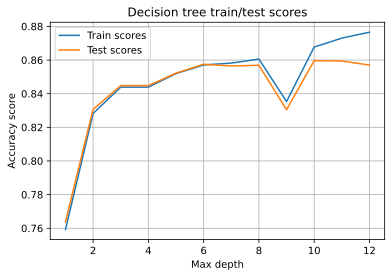

In [57]:
x = range(1, 13)
plt.plot(x, list(eval_scores_train.values()), label='Train scores')
plt.plot(x, list(eval_scores_test.values()), label='Test scores')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
# plt.ylim([0, 1])
plt.title('Decision tree train/test scores')
plt.grid()
plt.show()

### Underfitting and overfitting in random forest classifiers.

In [40]:
eval_scores_train = {}
eval_scores_test = {}

for estimators in [1] + list(range(0, 300, 50))[1:]:
    model_id = f'{estimators}'
    eval_scores_train[model_id] = []
    eval_scores_test[model_id] = []
    for depth in range(1, 13):
        model = RandomForestClassifier(max_depth=depth, n_estimators=estimators, n_jobs=8)
        model.fit(Xtrain_encoded, Ytrain_encoded)
        train_acc = accuracy_score(Ytrain_encoded, model.predict(Xtrain_encoded))
        test_acc = accuracy_score(Ytest_encoded, model.predict(Xtest_encoded))
        eval_scores_train[model_id].append(train_acc)
        eval_scores_test[model_id].append(test_acc)
        print(f'INFO. Model with depth={depth} and estimators={estimators}, achieved test accuracy of: {test_acc:.4f}')

INFO. Model with estimators=1, achieved test accuracy of: 0.7750
INFO. Model with estimators=1, achieved test accuracy of: 0.7678
INFO. Model with estimators=1, achieved test accuracy of: 0.7985
INFO. Model with estimators=1, achieved test accuracy of: 0.7974
INFO. Model with estimators=1, achieved test accuracy of: 0.7902
INFO. Model with estimators=1, achieved test accuracy of: 0.8435
INFO. Model with estimators=1, achieved test accuracy of: 0.8215
INFO. Model with estimators=1, achieved test accuracy of: 0.8223
INFO. Model with estimators=1, achieved test accuracy of: 0.8323
INFO. Model with estimators=1, achieved test accuracy of: 0.8364
INFO. Model with estimators=1, achieved test accuracy of: 0.8402
INFO. Model with estimators=1, achieved test accuracy of: 0.8352
INFO. Model with estimators=50, achieved test accuracy of: 0.7638
INFO. Model with estimators=50, achieved test accuracy of: 0.7742
INFO. Model with estimators=50, achieved test accuracy of: 0.8030
INFO. Model with estim

ValueError: ignored

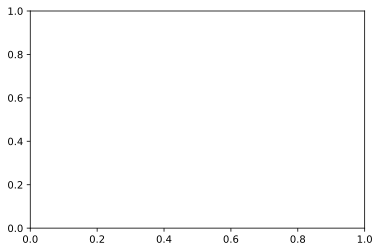

In [58]:
for n in eval_scores_train.keys():
    plt.plot(range(1, 13), eval_scores_train[n], '--', label=f'Train scores (n={n})', alpha=0.6)

# for n in eval_scores_test.keys():
#     plt.plot(range(1, 13), eval_scores_test[n], label=f'Test scores (n={n})', alpha=0.6)

plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
plt.title('Random Forest train/test scores')
# plt.xlim([0, 1])
plt.grid()
plt.show()

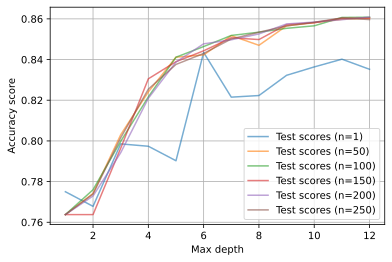

In [49]:
for n in eval_scores_test.keys():
    plt.plot(range(1, 13), eval_scores_test[n], label=f'Test scores (n={n})', alpha=0.6)

plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
plt.title('Random Forest train/test scores')
# plt.xlim([0, 1])
plt.grid()
plt.show()

> Some things that you might want to discuss in your report:
> * What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?
> * What happens with the curve for random forests as the ensemble size grows?
> * What happens with the best observed test set accuracy as the ensemble size grows?
> * What happens with the training time as the ensemble size grows?


## Task 3: Feature importances in random forest classifiers

### Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')
%matplotlib inline

# # Load Dataset
# filename = os.path.join(data_dir, 'iris.csv')
# data = pd.read_csv(filename)
# data_shuffled = data.sample(frac=1.0, random_state=0)
# X = data_shuffled.drop('species', axis=1)
# Y = data_shuffled['species']

# data_shuffled.head()

# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.4, random_state=0)
# clf = DecisionTreeClassifier()
# clf.fit(Xtrain, Ytrain);

#### Leaf

In [ ]:
class DecisionTreeLeaf:
    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

class DecisionTreeBranch:
    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

#### Decision Tree

In [ ]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

#### Tree Classifier

In [ ]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

In [ ]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

### Evaluation

> For the report. In your submitted report, please mention what value of max_depth you selected and what accuracy you got.

In [ ]:
model = TreeClassifier(max_depth=10, criterion='maj_sum')
model_score = aggregate_scores(cross_val_score(model, Xtrain, Ytrain))
print(model_score)

0.9099999999999999


In [ ]:
import itertools

depths = [1, 5, 10, 20]
criterions = ['maj_sum', 'info_gain', 'gini']
best_score = -1
scores = {}

for (d, c) in itertools.product(depths, criterions):
    model = TreeClassifier(max_depth=d, criterion=c)
    model_score = aggregate_scores(cross_val_score(model, Xtrain, Ytrain))
    scores[f'd={d}, c={c}'] = model_score
    print(f'INFO. Tree with depth {d} with criterion {c} achieved: {model_score:.4f}')
    if model_score > best_score:
        best_model = model
        best_depth = d
        best_criterion = c
        best_score = model_score
print(f'INFO. Tree with depth {best_depth} with criterion {best_criterion} achieved best score: {best_score}')

INFO. Tree with depth 1 with criterion maj_sum achieved: 0.8318
INFO. Tree with depth 1 with criterion info_gain achieved: 0.7806
INFO. Tree with depth 1 with criterion gini achieved: 0.8165
INFO. Tree with depth 5 with criterion maj_sum achieved: 0.9124
INFO. Tree with depth 5 with criterion info_gain achieved: 0.9159
INFO. Tree with depth 5 with criterion gini achieved: 0.9300
INFO. Tree with depth 10 with criterion maj_sum achieved: 0.9100
INFO. Tree with depth 10 with criterion info_gain achieved: 0.9294
INFO. Tree with depth 10 with criterion gini achieved: 0.9229
INFO. Tree with depth 20 with criterion maj_sum achieved: 0.9065
INFO. Tree with depth 20 with criterion info_gain achieved: 0.9300
INFO. Tree with depth 20 with criterion gini achieved: 0.9206
INFO. Tree with depth 5 with criterion gini achieved best score: 0.93


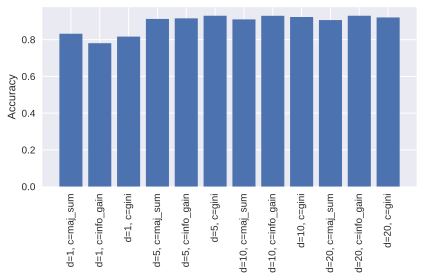

In [ ]:
fig, ax = plt.subplots()
linspace = [x for x in range(len(scores.keys()))]
plt.bar(linspace, scores.values())
plt.xticks(linspace, [f'{m}' for m in scores.keys()], rotation=90)
plt.grid(which='both', axis='y', zorder=1)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
best_model.fit(Xtrain, Ytrain)
acc = accuracy_score(Ytest, best_model.predict(Xtest))
print(f'INFO. Trained TreeClassifier model with max_depth={best_depth} reached test accuracy of: {acc:.4f}')

INFO. Trained TreeClassifier model with max_depth=5 reached test accuracy of: 0.9061


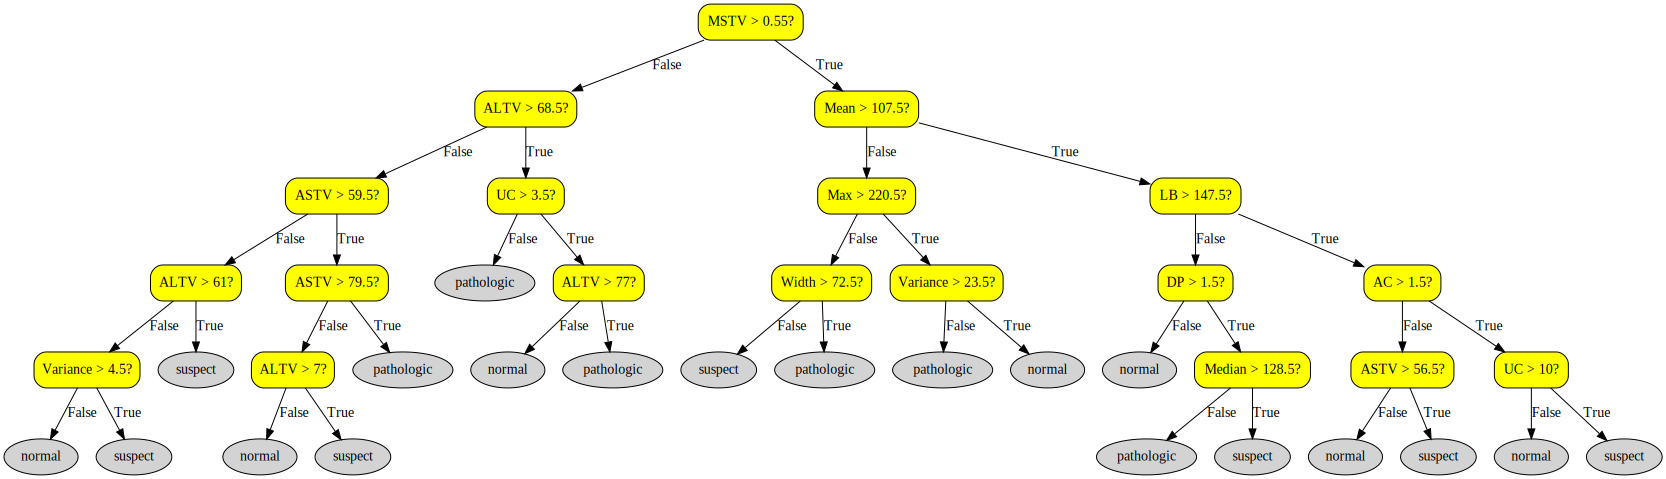

In [ ]:
best_model.draw_tree()

### Setup

In [ ]:
# Read the CSV file using Pandas.
filename = os.path.join(data_dir, 'sberbank.csv')
alldata = pd.read_csv(filename)

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
Xtrain.head()
# Ytrain.head()

,year,full_sq,life_sq,floor,num_room,kitch_sq,full_all
11042,2013,74,74.0,2.0,2.0,1.0,122862
11309,2013,60,1.0,23.0,2.0,1.0,156377
12432,2013,31,1.0,22.0,1.0,1.0,13890
9674,2013,37,20.0,12.0,1.0,10.0,156377
13000,2013,40,40.0,15.0,1.0,1.0,21155


### Baseline

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score']

array([-0.38697391, -0.39964814, -0.37373174, -0.38247357, -0.31537297])

### Evaluation


Since we are using the negative MSE, we should still search for the model that "maximizes the score".

In [ ]:
models = {
    'Baseline' : DummyRegressor(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=None),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=256),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=128, max_leaf_nodes=8),
    'MLPRegressor': MLPRegressor((128, 128, 128,), learning_rate_init=0.1, batch_size=128, max_iter=500),
}

scores = {}

for model_type in models.keys():
    model = models[model_type]
    score = cross_validate(model, Xtrain, Ytrain,
                           scoring='neg_mean_squared_error')['test_score']
    score = aggregate_scores(score)
    scores[model_type] = score
    print(f'INFO. Model {model_type} aggregated score: {score:.4f}')

best_model_type = max(scores, key=scores.get)
print('=' * 80)
print(f'INFO. Best Model is {best_model_type} with score: {scores[best_model_type]:.4f}')

INFO. Model Baseline aggregated score: -0.3716
INFO. Model LinearRegression aggregated score: -0.3432
INFO. Model Ridge aggregated score: -0.3431
INFO. Model Lasso aggregated score: -0.2960
INFO. Model DecisionTreeRegressor aggregated score: -0.6048
INFO. Model RandomForestRegressor aggregated score: -0.3097
INFO. Model GradientBoostingRegressor aggregated score: -0.2808


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


INFO. Model MLPRegressor aggregated score: -23.3665
INFO. Best Model is GradientBoostingRegressor with score: -0.2808


In [ ]:
from sklearn.metrics import mean_squared_error

models[best_model_type].fit(Xtrain, Ytrain)
neg_mse = mean_squared_error(Ytest, models[best_model_type].predict(Xtest))
print(f'INFO. Trained {best_model_type} reached MSE of: {neg_mse:.4f}')

INFO. Trained GradientBoostingRegressor reached MSE of: 0.2969


> For the report. In your submitted report, please include a description of the regression model you selected and report its evaluation score.

A GradientBoostingRegressor model is very similar to a GradientBoostingClassifier model (explained above). It's output doesn't need to be mapped to a probability distribution. Instead, its output is an accumulated continuos sum of the outputs of its weak learners, i.e. decision trees.

## Task 4: Decision trees for regression (Optional)

### Step 1. Implementing the Regression Model

In [ ]:
from sklearn.base import RegressorMixin

class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion # Unused
        
    def fit(self, X, Y):
        # Reference: https://scikit-learn.org/stable/modules/tree.html

        # # 'squared_error', 'friedman_mse', 'absolute_error', 'poisson'}, default='squared_error'
        # def squared_error_scorer(n_low, low_distr, n_high, high_distr):
        #     low_mean = np.mean(low_distr.values())
        #     high_mean = np.mean(high_distr.values())
        #     low_loss = np.sum((low_distr.values() - low_mean)**2) / n_low
        #     high_loss = np.sum((high_distr.values() - high_mean)**2) / n_high
        #     return (n_low * low_loss + n_high * high_loss) / (n_low + n_high)

        # # if self.criterion == 'squared_error':
        # #     self.criterion_function = squared_error_scorer
        # self.criterion_function = squared_error_scorer

        super().fit(X, Y)

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the mean value.
    def get_default_value(self, Y):
        # ======================================================================
        # TODO: To be changed
        # ======================================================================
        # self.distribution = Counter(Y)
        # return self.distribution.most_common(1)[0][0]
        self.distribution = Y
        return np.mean(self.distribution)

    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        # ======================================================================
        # TODO: To be changed
        # ======================================================================
        # return len(self.distribution) == 1
        variance_threshold = 1.0
        return np.var(self.distribution) < variance_threshold
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):
        # ======================================================================
        # TODO: To be changed
        # ======================================================================
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = np.array(list(X[sorted_indices, feature]))
        Y_sorted = np.array(list(Y[sorted_indices]))

        n = len(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        partial_low_squared_sum = np.sum(Y_sorted[0]**2)
        partial_low_sum_squared = np.sum(Y_sorted[0])

        partial_high_squared_sum = np.sum(Y_sorted[1:]**2)
        partial_high_sum_squared = np.sum(Y_sorted[1:])

        var_tot = np.var(Y_sorted)

        for i in range(0, n-1):
            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            partial_low_squared_sum += y_i**2
            partial_low_sum_squared += y_i

            partial_high_squared_sum -= y_i**2
            partial_high_sum_squared -= y_i

            n_low = i + 1
            n_high = n - n_low
            low_var = partial_low_squared_sum / n_low - partial_low_sum_squared**2 / (n_low**2)
            high_var = partial_high_squared_sum / n_high - partial_high_sum_squared**2 / (n_high**2)

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position, i. e. variance reduction
            score = tot_var - (n_high * high_var + n_low * low_var) / n
            print(score)
            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

### Step 2. Sanity Check

> The following function will generate a small number of training examples for a simple regression task with one input variable.

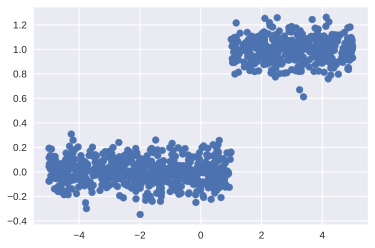

In [ ]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1 * np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

X, Y = make_some_data(1000)
plt.scatter(X, Y)
plt.show()

> For the report. If you consider the data-generating function, what kind of decision tree would we want to describe this data?

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

Let's do some training and prediction on the generated dataset.

In [ ]:
depths = [x for x in range(13)]
criterions = ['squared_error']
best_score = -1
scores = {}

for (d, c) in itertools.product(depths, criterions):
    model = TreeRegressor(max_depth=d, criterion=c)
    model.fit(Xtrain, Ytrain)
    score = cross_validate(model, Xtrain, Ytrain,
                        scoring='neg_mean_squared_error')['test_score']
    score = aggregate_scores(score)
    print(f'INFO. TreeRegressor max_depth={d} reached score: {score:.4f}')

INFO. TreeRegressor max_depth=0 reached score: -0.2473
INFO. TreeRegressor max_depth=1 reached score: -0.2473
INFO. TreeRegressor max_depth=2 reached score: -0.2473
INFO. TreeRegressor max_depth=3 reached score: -0.2473
INFO. TreeRegressor max_depth=4 reached score: -0.2473
INFO. TreeRegressor max_depth=5 reached score: -0.2473
INFO. TreeRegressor max_depth=6 reached score: -0.2473
INFO. TreeRegressor max_depth=7 reached score: -0.2473
INFO. TreeRegressor max_depth=8 reached score: -0.2473
INFO. TreeRegressor max_depth=9 reached score: -0.2473
INFO. TreeRegressor max_depth=10 reached score: -0.2473
INFO. TreeRegressor max_depth=11 reached score: -0.2473
INFO. TreeRegressor max_depth=12 reached score: -0.2473


### Step 3. Predicting apartment prices using decision tree regression

Let's load the dataset again.

In [ ]:
# Read the CSV file using Pandas.
filename = os.path.join(data_dir, 'sberbank.csv')
alldata = pd.read_csv(filename)

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
Xtrain.head()
# Ytrain.head()

,year,full_sq,life_sq,floor,num_room,kitch_sq,full_all
11042,2013,74,74.0,2.0,2.0,1.0,122862
11309,2013,60,1.0,23.0,2.0,1.0,156377
12432,2013,31,1.0,22.0,1.0,1.0,13890
9674,2013,37,20.0,12.0,1.0,10.0,156377
13000,2013,40,40.0,15.0,1.0,1.0,21155


Let's do cross-validation on the dataset.

In [ ]:
depths = [x for x in range(13)]
criterions = ['maj_sum', 'info_gain', 'gini']
best_score = -1
models = {}
scores = {}

for (d, c) in itertools.product(depths, criterions):
    model = TreeRegressor(max_depth=d, criterion=c)
    score = cross_validate(model, Xtrain, Ytrain,
                           scoring='neg_mean_squared_error')['test_score']
    score = aggregate_scores(score)
    scores[f'd={d}, c={c}'] = score
    models[f'd={d}, c={c}'] = model
    print(f'INFO. Tree with depth {d} with criterion {c} achieved: {score:.4f}')
    if score > best_score:
        best_model = f'd={d}, c={c}'
        best_score = score
print(f'INFO. Tree with {best_model} achieved best score: {scores[best_model]:.4f}')

INFO. Tree with depth 0 with criterion maj_sum achieved: -0.3716
INFO. Tree with depth 0 with criterion info_gain achieved: -0.3716
INFO. Tree with depth 0 with criterion gini achieved: -0.3716
INFO. Tree with depth 1 with criterion maj_sum achieved: -0.3716
INFO. Tree with depth 1 with criterion info_gain achieved: -0.3716
INFO. Tree with depth 1 with criterion gini achieved: -0.3716
INFO. Tree with depth 2 with criterion maj_sum achieved: -0.3716
INFO. Tree with depth 2 with criterion info_gain achieved: -0.3716
INFO. Tree with depth 2 with criterion gini achieved: -0.3716
INFO. Tree with depth 3 with criterion maj_sum achieved: -0.3716
INFO. Tree with depth 3 with criterion info_gain achieved: -0.3716
INFO. Tree with depth 3 with criterion gini achieved: -0.3716
INFO. Tree with depth 4 with criterion maj_sum achieved: -0.3716
INFO. Tree with depth 4 with criterion info_gain achieved: -0.3716
INFO. Tree with depth 4 with criterion gini achieved: -0.3716
INFO. Tree with depth 5 with c

Once the best model is identified, let's train and evaluate it on the dataset.

In [ ]:
from sklearn.metrics import mean_squared_error

models[best_model].fit(Xtrain, Ytrain)
neg_mse = mean_squared_error(Ytest, models[best_model].predict(Xtest))
print(f'INFO. Trained TreeRegressor reached MSE of: {neg_mse:.4f}')

INFO. Trained TreeRegressor reached MSE of: 0.4022


> For the report. In your submitted report, please describe what tree depth you used and the evaluation score you got on the test set.

### Step 4. Underfitting and overfitting

In [ ]:
eval_scores_train = {}
eval_scores_test = {}

for model_id in models.keys():
    models[model_id].fit(Xtrain, Ytrain)
    neg_mse_train = mean_squared_error(Ytrain, models[model_id].predict(Xtrain))
    neg_mse_test = mean_squared_error(Ytest, models[model_id].predict(Xtest))
    eval_scores_train[model_id] = neg_mse_train
    eval_scores_test[model_id] = neg_mse_test
eval_scores_test.values()

dict_values([0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155, 0.402233142382155])

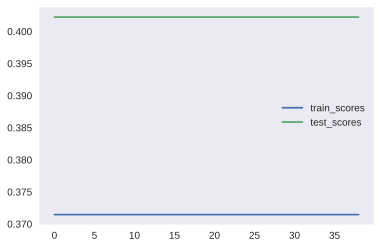

In [ ]:
# Plotting
# train_scores = eval_scores_train['gini' in eval_scores_train.keys()]
# test_scores = eval_scores_test['gini' in eval_scores_test.keys()]
plt.plot(list(eval_scores_train.values()), label='train_scores')
plt.plot(list(eval_scores_test.values()), label='test_scores')
plt.legend()
plt.grid()
plt.show()

> For the report. Please include this plot in the report, and comment on the differences between the two curves.

## Converting Notebook to PDF

This part and the following can be ignored.

In [ ]:
# %%capture
!apt-get update
!apt-get install inkscape
!add-apt-repository universe
!add-apt-repository ppa:inkscape.dev/stable
!apt-get update
!apt install inkscape

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
%%capture
import re

ASSIGNMENT_NAME = 'DAT340 - Assignment ' + ASSIGNMENT_ID.split('_')[1]
pdf_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
pdf_dir = os.path.join(pdf_dir, 'Colab Notebooks', 'dat340', ASSIGNMENT_ID)
pdf_filename = re.escape(os.path.join(pdf_dir, ASSIGNMENT_NAME)) + '.ipynb'

!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=False $pdf_filename

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/dat340/assignment_1/DAT340 - Assignment 1.ipynb to pdf
Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused
[NbConvertApp] Support files will be in DAT340 - Assignment 1_files/
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[NbConvertApp] Making directory ./DAT340 - Assignment 1_files
[